### 과일 데이터를 CNN으로 image 분류 하기

In [1]:
import numpy as np

In [2]:
fruits = np.load('./Data/fruits.npy')

In [3]:
fruits.shape

(300, 100, 100)

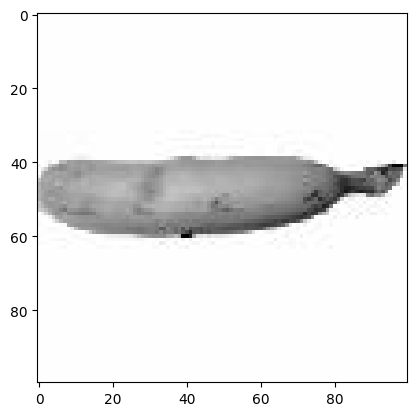

In [7]:
import matplotlib.pyplot as plt

plt.imshow(
    fruits[200],
    cmap='gray_r'
)

### Target 만들기

In [8]:
# 0 : apple , 1 : pineapple , 2: banana
target = np.concatenate([np.zeros(100),np.ones(100),np.full(100,2)])

### CNN 적용해서 심층신경망 만들기

In [10]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [13]:
max = 0
for i in range(300):
    max_temp = fruits[i].max() 
    if max_temp > max:
        max = max_temp

max

255

In [14]:
min = 0
for i in range(300):
    min_temp = fruits[i].min() 
    if min_temp < min:
        min = min_temp

min

0

In [15]:
# scale 하기
fruits_scaled = fruits.reshape(-1,100,100,1) / 255.0

In [42]:
# test train 나누기
train_scaled , test_scaled , train_target , test_target = \
    train_test_split(fruits_scaled,target,test_size=0.2)

In [43]:
# train val 나누기
train_scaled , val_scaled , train_target , val_target = \
    train_test_split(train_scaled,train_target,test_size=0.2)

In [61]:
print(train_scaled.shape)
print(val_scaled.shape)
print(test_scaled.shape)

(192, 100, 100, 1)
(48, 100, 100, 1)
(60, 100, 100, 1)


In [68]:
# 딥러닝 모델 만들기
model = keras.Sequential()

# 합성곱 층 (CNN)
model.add(keras.layers.Conv2D(
    32,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same',
    input_shape = (100,100,1)
))

# pooling
model.add(keras.layers.MaxPooling2D(
    2
))

model.add(keras.layers.Conv2D(
    64,
    kernel_size=3,
    activation='relu',
    padding='same'
))

model.add(keras.layers.MaxPooling2D(
    2
))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./Data/best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

hist = model.fit(train_scaled,
                 train_target,
                 epochs=20,
                 validation_data = (val_scaled,val_target),
                 callbacks=[checkpoint_cb,early_stopping_cb]
                 )

Epoch 1/20
6/6 [==============================] - 1s 106ms/step - loss: 0.8656 - accuracy: 0.5938 - val_loss: 0.3414 - val_accuracy: 0.9792
Epoch 2/20
6/6 [==============================] - 1s 97ms/step - loss: 0.2330 - accuracy: 0.9635 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 1s 106ms/step - loss: 0.0530 - accuracy: 0.9948 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 1s 100ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.7395e-04 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 1s 103ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.5135e-04 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 1s 110ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 8.1353e-05 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 1s 113ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5498e-04 - val_accuracy: 1.0000
Epoch

In [75]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 40000)             0         
                                                                 
 dense_24 (Dense)            (None, 100)             

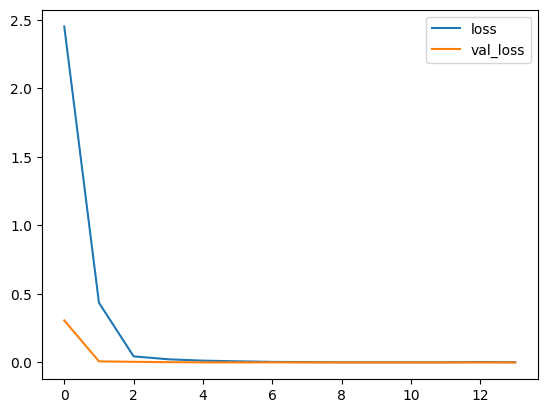

In [64]:
plt.plot(
    hist.history['loss'],
    label = 'loss'
)

plt.plot(
    hist.history['val_loss'],
    label = 'val_loss'
)

plt.legend()

plt.show()

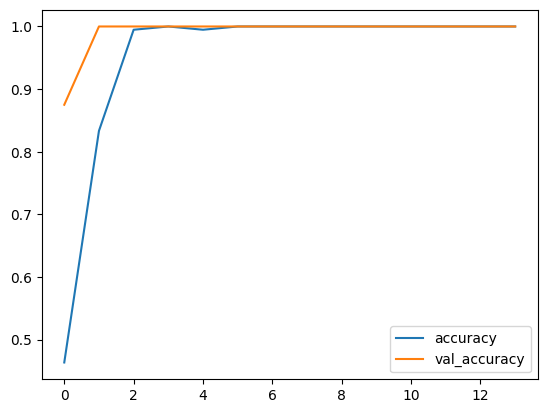

In [65]:
plt.plot(
    hist.history['accuracy'],
    label = 'accuracy'
)

plt.plot(
    hist.history['val_accuracy'],
    label = 'val_accuracy'
)

plt.legend()

plt.show()

In [52]:
model.evaluate(val_scaled,val_target)

2/2 [==============================] - 0s 13ms/step - loss: 3.7923e-06 - accuracy: 1.0000


[3.7923080071777804e-06, 1.0]

### test로 일반화 시키기

In [53]:
model.evaluate(test_scaled,test_target)

2/2 [==============================] - 0s 35ms/step - loss: 1.1668e-04 - accuracy: 1.0000


[0.00011668229853967205, 1.0]

1/1 [==============================] - 0s 11ms/step


'banana'

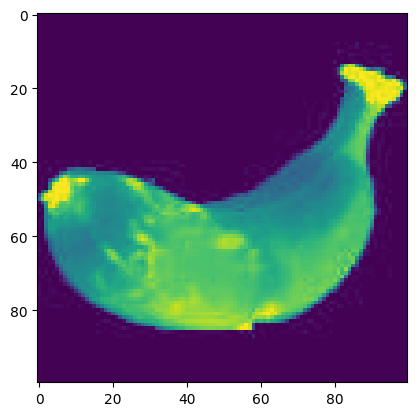

In [95]:
plt.imshow(
    test_scaled[25].reshape(100,100),
    # cmap='gray'
)

classes = ['apple','pineapple','banana']
classes[np.argmax(model.predict(test_scaled[25:26]))]

### 번외 : 가중치 확인해보기

In [98]:
# 4차원 데이터다. 애매하다. 
model.weights

[<tf.Variable 'conv2d_28/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[ 0.06068888, -0.04852466, -0.08711131, -0.11361974,
           -0.07585882, -0.03708557,  0.0218362 ,  0.09980817,
           -0.1355619 , -0.08647351,  0.10287116, -0.09371464,
            0.07382803, -0.06072512,  0.11882512, -0.03563103,
            0.11001304,  0.13457483,  0.10676324,  0.05211272,
           -0.10032097,  0.09291691, -0.0632467 ,  0.00205522,
           -0.03357676,  0.09050371,  0.10514264,  0.02536444,
           -0.04361123,  0.11921982, -0.04231326, -0.13407622]],
 
         [[ 0.03741041, -0.05105326, -0.03372309,  0.13089651,
            0.11535311,  0.12311261,  0.07433609, -0.03140767,
           -0.04165355, -0.01693072,  0.09090696,  0.08564716,
           -0.07033001,  0.14246525, -0.05489395,  0.02948296,
            0.00388193, -0.12039252, -0.1051781 , -0.10918123,
           -0.08075228, -0.074604  ,  0.01425329, -0.09461635,
           -0.09364171, -0.00398345, 